In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from autograd_lib import autograd_lib
from collections import defaultdict
from tqdm import tqdm
# prevent "kernel died" error because of matplotlib:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from IPython.display import clear_output

In [2]:
torch.manual_seed(1)
np.random.seed(1)

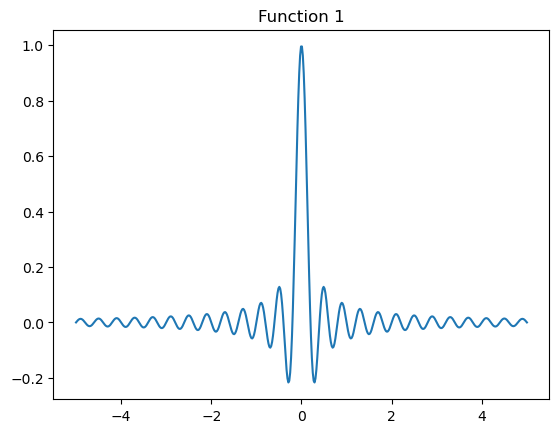

In [3]:
# input function
x = torch.linspace(-5,5,500)
x = torch.unsqueeze(x,dim=1)
y = (np.sin(5*np.pi*x))/5/np.pi/x

x = x.clone().detach()
y = y.clone().detach()

plt.plot(x, y)
plt.title('Function 1')
plt.show()

In [4]:
# models
class model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(1,5),
                nn.ReLU(),
                nn.Linear(5,10),
                nn.ReLU(),
                nn.Linear(10,10),
                nn.ReLU(),
                nn.Linear(10,10),
                nn.ReLU(),
                nn.Linear(10,10),
                nn.ReLU(),
                nn.Linear(10,10),
                nn.ReLU(),
                nn.Linear(10,5),
                nn.ReLU(),
                nn.Linear(5,1)
        )
        self.loss_fnc = nn.MSELoss()

    def forward(self, x):
        return self.layers(x)

In [5]:
def train_fnc(model, x, y, n_epoch):
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    for ep in range(n_epoch):
        y_pred = model(x)
        loss = model.loss_fnc(y_pred, y)
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        if (ep+1)%500==0:
            print('Epoch #: {}, Loss = {}'.format(ep,loss.detach().numpy()))
    return model

In [6]:
def CH(layer, _, B):
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A)
    H[layer] += torch.einsum('nli,nkj->likj', BA, BA)

def SA(layer, A, _):
    activations[layer] = A

def find_min_ratio(model, OF, x, y):
    model.zero_grad()
    with autograd_lib.module_hook(SA):
        y_pred = model(x)
        loss = OF(y_pred, y)

    # hessian
    with autograd_lib.module_hook(CH):
        autograd_lib.backward_hessian(y_pred, loss='LeastSquares')

    # hessian eigenvalues
    hes = list(H.values())
    min_ratio = []
    for hes_ in hes:
        s = hes_.shape[1] * hes_.shape[0]
        hes_ = hes_.reshape(s,s)
        eig = torch.linalg.eigvalsh(hes_)
        min_ratio.append(torch.sum(eig>0).item() / len(eig))
    return np.mean(min_ratio) 

In [7]:
def loss_g_norm(model, OF, x, y):
    model.train()
    model.zero_grad()
    y_pred = model(x)
    loss = OF(y_pred, y)
    loss.backward()

    GNs = []
    for l in model.modules():
        if isinstance(l, nn.Linear):
            LGN = l.weight.grad.norm(2).item()
            GNs.append(LGN)
    grad_norm = np.mean(GNs)
    
    return loss, grad_norm

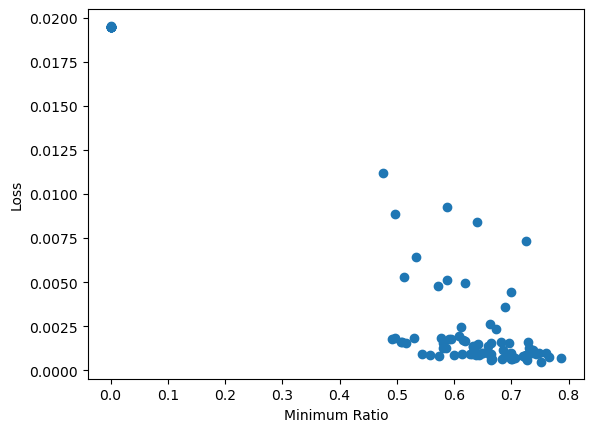

In [8]:
if __name__=='__main__':
    min_ratios = []
    grad_norms = []
    losses = []
    n_epochs = 1000
    
    for i in tqdm(range(100)):
        H = defaultdict(float)
        activations = defaultdict(int)
        
        model = train_fnc(model1(), x, y, n_epochs)
        autograd_lib.register(model)
    
        OF = nn.MSELoss()
        loss, grad_norm = loss_g_norm(model, OF, x, y)
        try:
            min_ratio = find_min_ratio(model, OF, x, y)
        except:
            print('skipped')
            continue
    
        grad_norms.append(grad_norm)
        losses.append(loss)
        min_ratios.append(min_ratio)

    # plot
    clear_output()
    min_r=[]
    LOSS=[]
    for i in range(len(grad_norms)):
        if grad_norms[i] < 0.1:
            min_r.append(min_ratios[i])
            LOSS.append(losses[i].detach().cpu().numpy())
    plt.scatter(min_r, LOSS)
    plt.xlabel('Minimum Ratio')
    plt.ylabel('Loss')
    plt.show()